In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from utils import load_anything, get_basename, path_of, norm, float_to_uint16, care_align, quantile_image, quantile_image_minmax, hill, mip, upsample3d, iou, iou_cuda, get_best_iou
import tifffile
import torch
import torch.nn.functional as F

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from tqdm import tqdm

In [2]:
base = "_results_for_paper"

# fig. 2 our simulation data

/tmp/ipykernel_3724809/1074540147.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(w_pad=wspace)


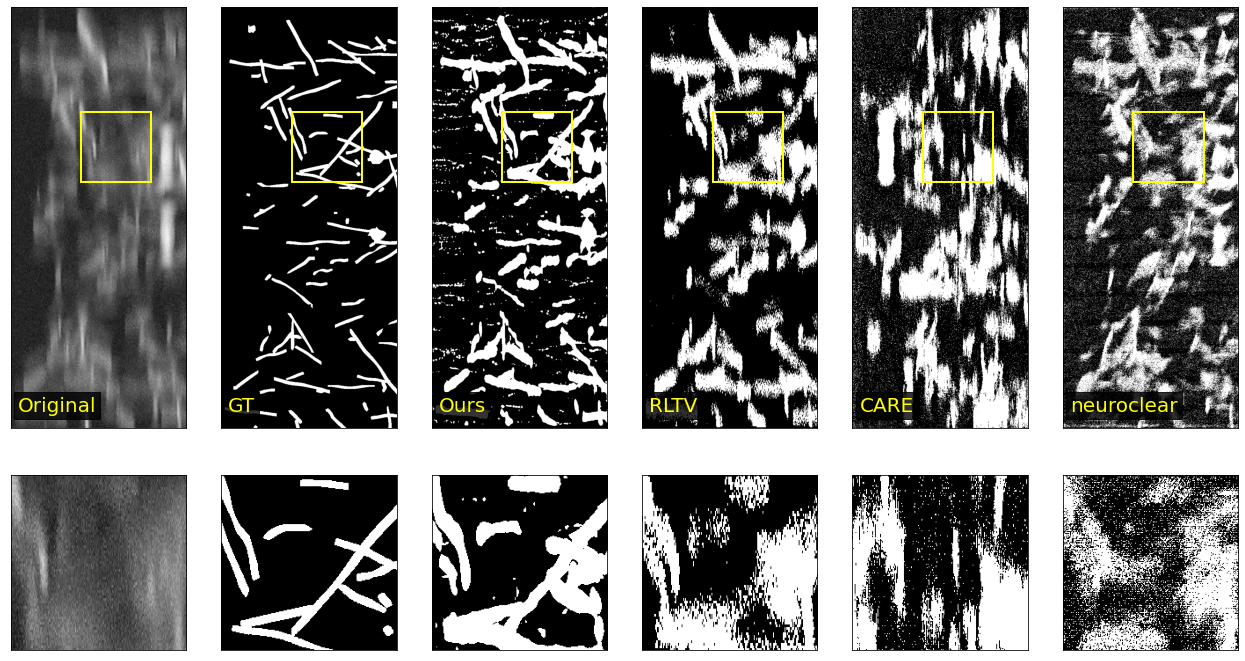

In [3]:
idx = 3
original   = tifffile.imread(path_of(base, "fig2_o", "original"  , idx))[0]
label      =         np.load(path_of(base, "fig2_o", "label"     , idx))[0]
care       = tifffile.imread(path_of(base, "fig2_o", "care_new"  , idx))
deconv     = tifffile.imread(path_of(base, "fig2_o", "deconv"    , idx))
neuroclear = tifffile.imread(path_of(base, "fig2_o", "result_0420_sim", idx))
tenet      = tifffile.imread(path_of(base, "fig2_o", "tenet"     , idx))[0]

# preprocess to 0 to 1
original    = upsample3d(hill(norm(original  , bit=16)))
deconv      = upsample3d(hill(deconv/deconv.max()))
neuroclear  = (norm(neuroclear, bit=16))
care       /= care.max()
tenet       = norm(tenet)

# functions to generate
def figure_2_a(figures, sec, start, range, 
               x_start,
               x_end  ,
               y_start,
               y_end  ,
               figsize = (20, 20),
               bounding_box_1_x_loc  = 150,
               bounding_box_1_y_loc  =   0,
               bounding_box_1_x_size = 200,
               bounding_box_1_y_size = 150,
               wspace=0, 
               color = "yellow",
               title_font_size = 16,
               ):
    
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(3, len(figures), figure=fig, wspace=0.2)
    fig.set_facecolor('white')
    line_values = []
    for i, img in enumerate(figures):
        # show large image
        ax = fig.add_subplot(gs[0:2, i])
        #if img[1]=="Original":
        #    scalebar = AnchoredSizeBar(ax.transData,
        #                   65, '20 µm', 'lower right', 
        #                   pad=0.3,
        #                   color=color,
        #                   frameon=False,
        #                   size_vertical=3,
        #                   fontproperties=fm.FontProperties(size=16),
        #                    )
        #    ax.add_artist(scalebar)
        # set bounding box1
        rect = patches.Rectangle(
            (bounding_box_1_x_loc , bounding_box_1_y_loc),
             bounding_box_1_x_size, bounding_box_1_y_size,
            linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        # set title
        ax.text(20,1150, img[1], fontsize=title_font_size, color=color,
                bbox=dict(facecolor="black", alpha=0.8))
        # remove axis
        ax.set_xticks([])
        ax.set_yticks([])
        image_to_show = mip(img[0], sec=sec, start=start, range=range,
                            )[y_start:y_end, x_start:x_end,]
        if img[1] == "RLTV" and img[2] != -1:
            image_to_show = image_to_show > img[2]
        if img[1] == "CARE" and img[2] != -1:
            image_to_show = image_to_show > img[2]
        if img[1] == "neuroclear" and img[2] != -1:
            image_to_show = image_to_show > img[2]
        vmin = image_to_show.min()
        vmax = image_to_show.max()
        ax.imshow(image_to_show , cmap="gray",vmin=vmin, vmax=vmax)
        # show image in bounding box 1
        ax = fig.add_subplot(gs[2, i])
        ax.set_xticks([])
        ax.set_yticks([])
        image_to_zoom1 = image_to_show[
            bounding_box_1_y_loc:bounding_box_1_y_loc+bounding_box_1_y_size,
            bounding_box_1_x_loc:bounding_box_1_x_loc+bounding_box_1_x_size,
        ]
        ax.imshow(image_to_zoom1, cmap="gray", vmin=vmin, vmax=vmax)
    plt.tight_layout(w_pad=wspace)
    plt.show()
    return fig, line_values

# plot here
figures = [
    [original  , "Original"   ],
    [label     , "GT"         ],
    [tenet     , "Ours"       ],
    [deconv    , "RLTV"       , get_best_iou(deconv,label,bins=256)[1]      ],
    [care      , "CARE"       , get_best_iou(care, label, bins=256)[1]      ],
    [neuroclear, "neuroclear" , get_best_iou(neuroclear, label, bins=256)[1]],
]

fig_2_a, line_values = figure_2_a(
    figures,
    sec      = "yz"     ,
    start    = 200      ,
    range    = 100      ,
    x_start  = 0        ,
    x_end    = -1       ,
    y_start  = 0        ,
    y_end    = -1       ,
    figsize  = (22,12)  ,
    bounding_box_1_x_loc  = 200,
    bounding_box_1_y_loc  = 300,
    bounding_box_1_x_size = 200,
    bounding_box_1_y_size = 200,
    wspace                = 0.8,
    color                 = "yellow",
    title_font_size       = 20,
)

## d IoU of above

In [4]:
iou_care       = np.zeros(16)
iou_deconv     = np.zeros(16)
iou_neuroclear = np.zeros(16)
iou_tenet      = np.zeros(16)

for idx in tqdm(range(16),
                bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}"):
    label      =         np.load(path_of(base, "fig2_o", "label"     , idx))[0]
    care       = tifffile.imread(path_of(base, "fig2_o", "care_new"  , idx))
    deconv     = tifffile.imread(path_of(base, "fig2_o", "deconv"    , idx))
    neuroclear = tifffile.imread(path_of(base, "fig2_o", "result_0420_sim", idx))
    tenet      = tifffile.imread(path_of(base, "fig2_o", "tenet"     , idx))[0]

    # preprocess to 0 to 1
    deconv      = upsample3d(hill(deconv/deconv.max()))
    neuroclear  = (norm(neuroclear, bit=16))
#    care        = quantile_image(care_align(care), q_max=0.99)
    care        = care_align(care)
    care       /= care.max()
    tenet       = norm(tenet)
    iou_care[idx]       = get_best_iou(care      , label, bins=256, smooth=0)[0]
    iou_deconv[idx]     = get_best_iou(deconv    , label, bins=256, smooth=0)[0]
    iou_neuroclear[idx] = get_best_iou(neuroclear, label, bins=256, smooth=0)[0]
    iou_tenet[idx]      = iou_cuda(tenet, label, smooth=0)

print(iou_deconv    .mean())
print(iou_care      .mean())
print(iou_neuroclear.mean())
print(iou_tenet     .mean())

100%|██████████| 16/16 [04:30<00:00, 16.93s/it]

0.22557597886770964
0.14798919390887022
0.05553639796562493
0.3518974967300892


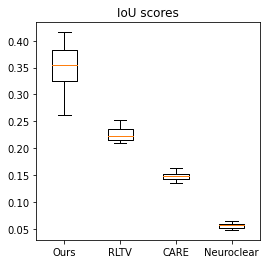

In [5]:
ious = [
    iou_tenet     ,
    iou_deconv    ,
    iou_care      ,
    iou_neuroclear,
        ]
labels = [
    "Ours"       ,
    "RLTV"       , 
    "CARE"       , 
    "Neuroclear" ,
    ]

def figure_2_d(ious, labels, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.boxplot(np.array(ious).transpose(1,0),
            labels=labels)
    plt.title("IoU scores",fontsize=20)
    plt.show()

fig_2_d = figure_2_d(ious, labels, (4,4))

/tmp/ipykernel_3724809/1074540147.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(w_pad=wspace)


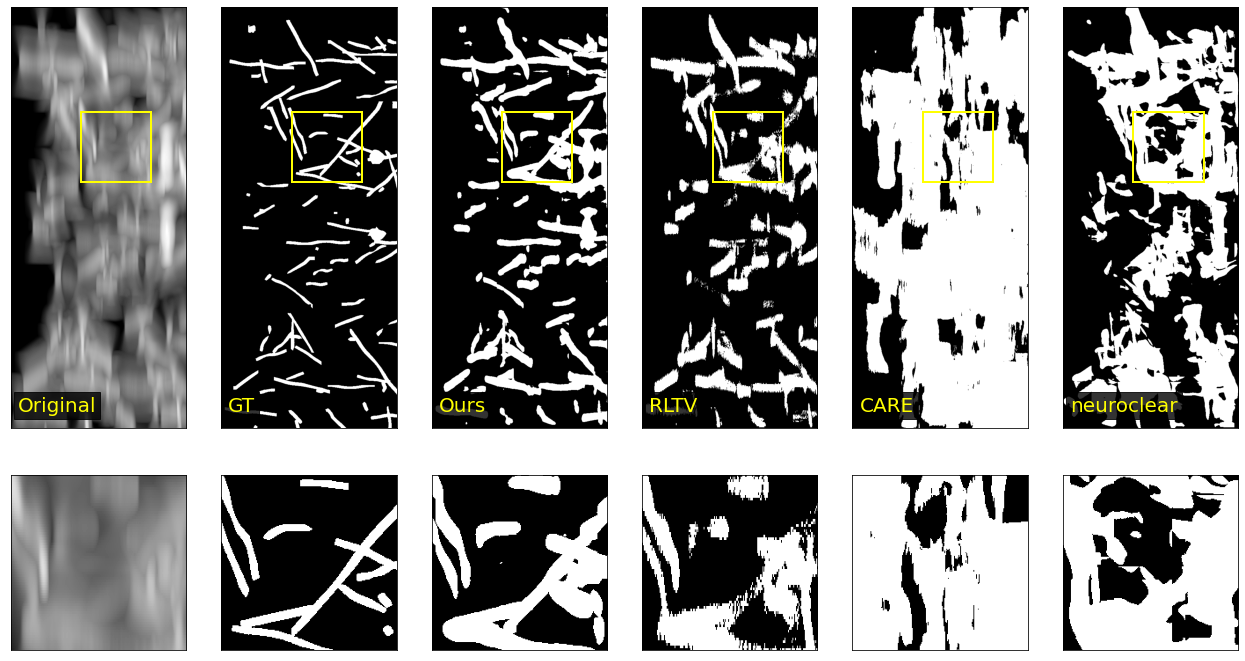

In [6]:
idx = 3
original   = tifffile.imread(path_of(base, "fig2_o/no_noise", "original"  , idx))
label      =         np.load(path_of(base, "fig2_o"         , "label"     , idx))[0]
care       = tifffile.imread(path_of(base, "fig2_o/no_noise", "care"      , idx))
deconv     = tifffile.imread(path_of(base, "fig2_o/no_noise", "deconv"    , idx))
neuroclear = tifffile.imread(path_of(base, "fig2_o/no_noise", "neuroclear", idx))
tenet      = tifffile.imread(path_of(base, "fig2_o/no_noise", "tenet"     , idx))[0]

# preprocess to 0 to 1
original    = upsample3d(hill(norm(original  , bit=16)))
deconv      = upsample3d(hill(deconv/deconv.max()))
neuroclear  = (norm(neuroclear, bit=16))
#care        = quantile_image(care_align(care), q_max=0.99)
care       /= care.max()
tenet       = norm(tenet)

# plot here
figures = [
    [original  , "Original"   ],
    [label     , "GT"         ],
    [tenet     , "Ours"       ],
    [deconv    , "RLTV"       , get_best_iou(deconv,label,bins=256)[1]      ],
    [care      , "CARE"       , get_best_iou(care, label, bins=256)[1]      ],
    [neuroclear, "neuroclear" , get_best_iou(neuroclear, label, bins=256)[1]],
]

fig_2_a, line_values = figure_2_a(
    figures,
    sec      = "yz"     ,
    start    = 200      ,
    range    = 100      ,
    x_start  = 0        ,
    x_end    = -1       ,
    y_start  = 0        ,
    y_end    = -1       ,
    figsize  = (22,12)  ,
    bounding_box_1_x_loc  = 200,
    bounding_box_1_y_loc  = 300,
    bounding_box_1_x_size = 200,
    bounding_box_1_y_size = 200,
    wspace                = 0.8,
    color                 = "yellow",
    title_font_size       = 20,
)

In [7]:
iou_no_noise_care       = np.zeros(16)
iou_no_noise_deconv     = np.zeros(16)
iou_no_noise_neuroclear = np.zeros(16)
iou_no_noise_tenet      = np.zeros(16)

for idx in tqdm(range(16),
                bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}"):
    label      =         np.load(path_of(base, "fig2_o", "label", idx))[0]
    care       = tifffile.imread(path_of(base, "fig2_o/no_noise", "care", idx))
    deconv     = tifffile.imread(path_of(base, "fig2_o/no_noise", "deconv", idx))
    neuroclear = tifffile.imread(path_of(base, "fig2_o/no_noise", "neuroclear", idx))
    tenet      = tifffile.imread(path_of(base, "fig2_o/no_noise", "tenet", idx))[0]
    # preprocess to 0 to 1
    deconv      = upsample3d(hill(deconv/deconv.max()))
    neuroclear  = (norm(neuroclear, bit=16))
#    care        = quantile_image(care_align(care), q_max=0.99)
    care        = care_align(care)
    care       /= care.max()
    tenet       = norm(tenet)
    iou_no_noise_care[idx]       = get_best_iou(care      , label, bins=256, smooth=0)[0]
    iou_no_noise_deconv[idx]     = get_best_iou(deconv    , label, bins=256, smooth=0)[0]
    iou_no_noise_neuroclear[idx] = get_best_iou(neuroclear, label, bins=256, smooth=0)[0]
    iou_no_noise_tenet[idx]      = iou_cuda(tenet, label, smooth=0)

print(iou_no_noise_deconv    .mean())
print(iou_no_noise_care      .mean())
print(iou_no_noise_neuroclear.mean())
print(iou_no_noise_tenet     .mean())

100%|██████████| 16/16 [04:36<00:00, 17.26s/it]

0.2911590076982975
0.08299894398078322
0.06592693622224033
0.3795248307287693


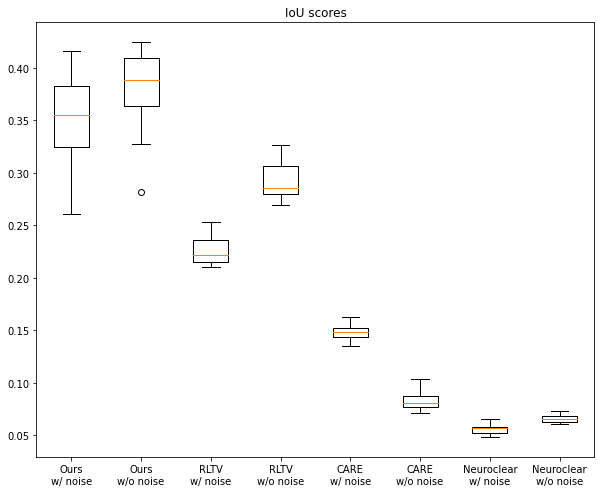

In [8]:
ious = [

    iou_tenet     ,
    iou_no_noise_tenet     ,
    iou_deconv    ,
    iou_no_noise_deconv    ,
    iou_care      ,
    iou_no_noise_care      ,
    iou_neuroclear,
    iou_no_noise_neuroclear,
]

labels = [
    "Ours\nw/ noise"       ,
    "Ours\nw/o noise"       ,
    "RLTV\nw/ noise"       , 
    "RLTV\nw/o noise"       , 
    "CARE\nw/ noise"       , 
    "CARE\nw/o noise"       , 
    "Neuroclear\nw/ noise" ,
    "Neuroclear\nw/o noise" ,
    ]

fig_2_d = figure_2_d(ious, labels, (10,8))

# fig.2 adversarial simulation data
## b explanation of experiment

In [4]:
# load all images needed
original00 = tifffile.imread(path_of(base, "fig2_a", "original", 0))[0]
original45 = tifffile.imread(path_of(base, "fig2_a", "original", 1))[0]
original90 = tifffile.imread(path_of(base, "fig2_a", "original", 2))[0]
label00    = tifffile.imread(path_of(base, "fig2_a", "label"   , 0))
label45    = tifffile.imread(path_of(base, "fig2_a", "label"   , 1))
label90    = tifffile.imread(path_of(base, "fig2_a", "label"   , 2))
original00 = upsample3d((norm(original00)))
original45 = upsample3d((norm(original45)))
original90 = upsample3d((norm(original90)))

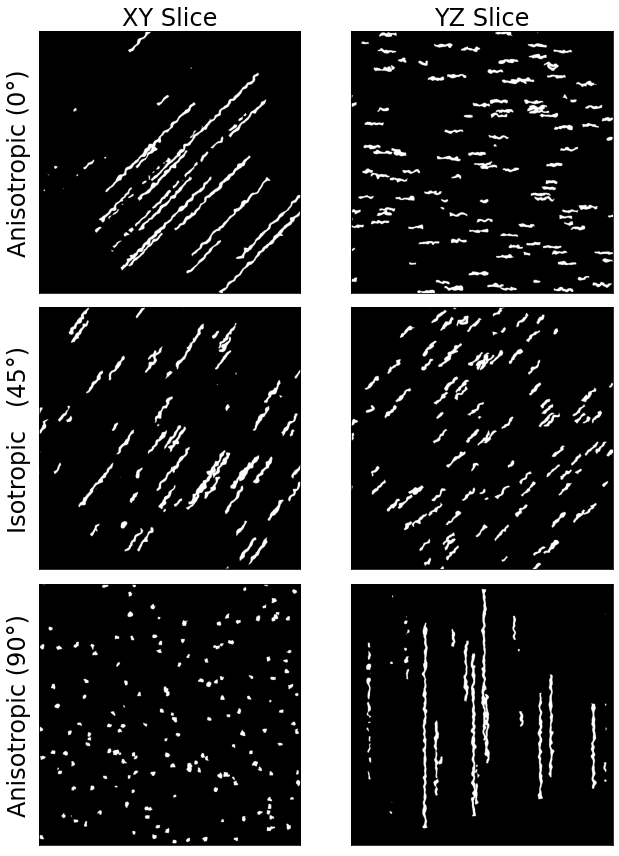

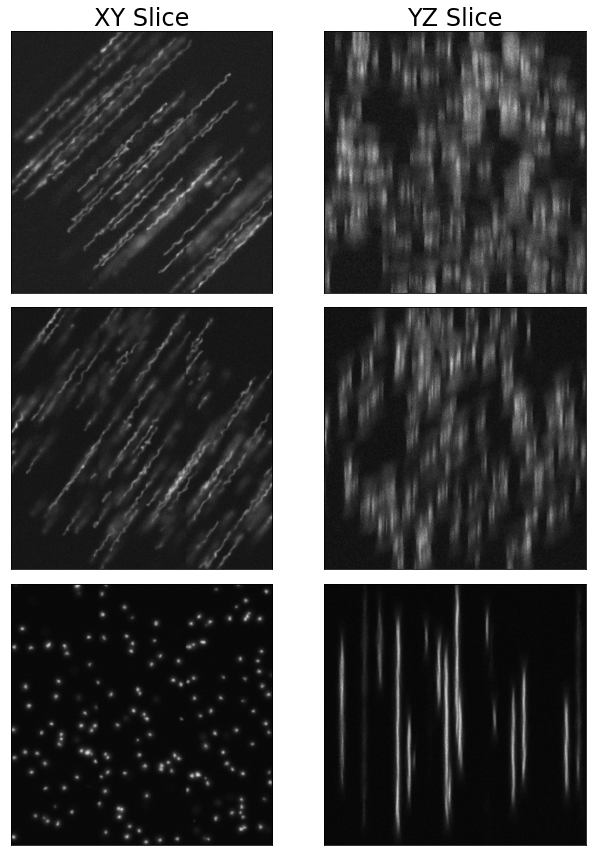

In [5]:
# functions to generate images
def figure_2_b(figures  ,
               sec0     ,
               sec1     ,
               start0   ,
               start1   ,
               range0   ,
               range1   ,
               x_start  ,
               x_end    ,
               y_start  ,
               y_end    ,
               figsize  ,
               fontsize ,
               figname  ,
               ):
    fig = plt.figure(figsize=figsize)
    fig.set_facecolor('white')
    gs = gridspec.GridSpec(len(figures), 2, figure=fig, wspace=0)
    for i, figure in enumerate(figures):
        ax = fig.add_subplot(gs[i, 0])
        ax.set_xticks([])
        ax.set_yticks([])
        if i == 0:
            ax.set_title(label=sec0.upper()+" Slice", fontsize=fontsize)
        ax.set_ylabel(figure[1], fontsize=fontsize)
        image_to_show = mip(figure[0]  ,
                            sec=sec0   ,
                            start=start0,
                            range=range0,
                            )
        ax.imshow(image_to_show[y_start:y_end, x_start:x_end],
                  cmap="gray")
        ax = fig.add_subplot(gs[i, 1])
        ax.set_xticks([])
        ax.set_yticks([])
        if i == 0:
            ax.set_title(label=sec1.upper()+" Slice", fontsize=fontsize)
        image_to_show = mip(figure[0],
                    sec=sec1,
                    start=start1,
                    range=range1,
                    )
        ax.imshow(image_to_show[y_start:y_end, x_start:x_end],
                  cmap="gray")
    plt.tight_layout()
    plt.savefig(figname)
    plt.show()
    return fig

    
sec0    = "xy"
sec1    = "yz"
start0  = 425
start1  = 425
range0  = 50
range1  = 50
x_start =  0
x_end   = -1
y_start =  0
y_end   = -1
figsize = (9, 12)
fontsize = 24

figures = [
    [label00, "Anisotropic (0\u00B0)"  ],
    [label45, "Isotropic   (45\u00B0)" ],
    [label90, "Anisotropic (90\u00B0)" ],
    ]
fig_2_b_label = figure_2_b(
    figures = figures  ,
    sec0    = sec0     ,
    sec1    = sec1     ,
    start0  = start0   ,
    start1  = start1   ,
    range0  = range0   ,
    range1  = range1   ,
    x_start = x_start  ,
    x_end   = x_end    ,
    y_start = y_start  ,
    y_end   = y_end    ,
    figsize = figsize  ,
    fontsize = fontsize,
    figname  = "_results_for_paper/fig2_a/labels.pdf"
)

figures = [
    [original00, ""],
    [original45, ""],
    [original90, ""],
    ]

fig_2_b_original = figure_2_b(
    figures = figures  ,
    sec0    = sec0     ,
    sec1    = sec1     ,
    start0  = start0   ,
    start1  = start1   ,
    range0  = range0   ,
    range1  = range1   ,
    x_start = x_start  ,
    x_end   = x_end    ,
    y_start = y_start  ,
    y_end   = y_end    ,
    figsize = figsize  ,
    fontsize = fontsize,
    figname  = "_results_for_paper/fig2_a/originals.pdf"
)


In [6]:
original00_no_noise = tifffile.imread(path_of(base, "fig2_a/no_noise", "original", 0))[0]
original45_no_noise = tifffile.imread(path_of(base, "fig2_a/no_noise", "original", 1))[0]
original90_no_noise = tifffile.imread(path_of(base, "fig2_a/no_noise", "original", 2))[0]
original00_no_noise = upsample3d((norm(original00_no_noise)))
original45_no_noise = upsample3d((norm(original45_no_noise)))
original90_no_noise = upsample3d((norm(original90_no_noise)))

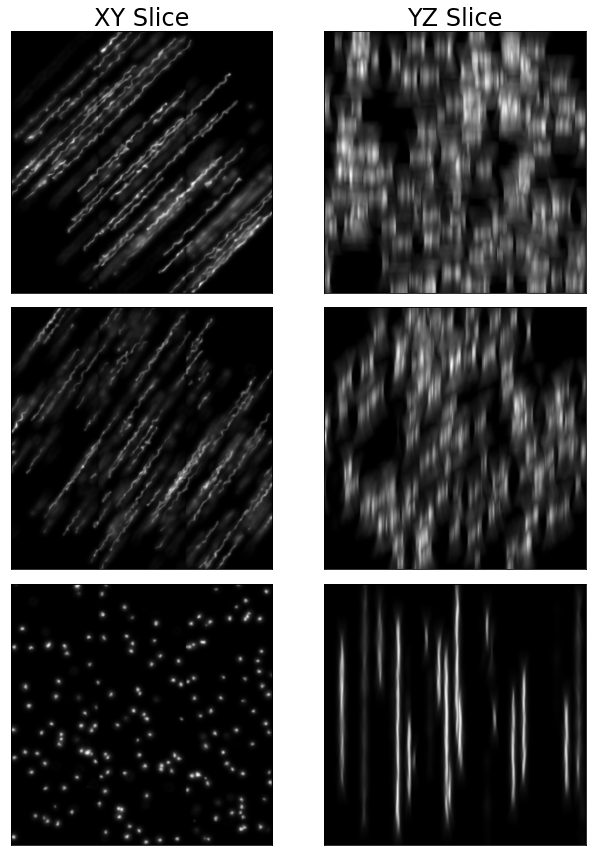

In [7]:
figures = [
    [original00_no_noise, "" ],
    [original45_no_noise, ""],
    [original90_no_noise, ""],
    ]

fig_2_b_original = figure_2_b(
    figures = figures  ,
    sec0    = sec0     ,
    sec1    = sec1     ,
    start0  = start0   ,
    start1  = start1   ,
    range0  = range0   ,
    range1  = range1   ,
    x_start = x_start  ,
    x_end   = x_end    ,
    y_start = y_start  ,
    y_end   = y_end    ,
    figsize = figsize  ,
    fontsize = fontsize,
    figname  = "_results_for_paper/fig2_a/originals.pdf"
)

## c

In [1]:
def figure_2_c(figures  ,
               sec     ,
               start   ,
               range   ,
               x_start  ,
               x_end    ,
               y_start  ,
               y_end    ,
               figsize  ,
               fontsize ,
               figname  ,
               ):
    fig = plt.figure(figsize=figsize)
    fig.set_facecolor('white')
    gs = gridspec.GridSpec(3, len(figures), figure=fig, wspace=0)
    for i, figure in enumerate(figures):
        for j, img in enumerate(figure[0]):
            ax = fig.add_subplot(gs[j, i])
            ax.set_xticks([])
            ax.set_yticks([])
            if j == 0:
                ax.set_title(label=figure[1], fontsize=fontsize)
            
            if i == 0:
                ax.set_ylabel(f"{j*45}", fontsize=fontsize)
            
            image_to_show = mip(img        ,
                                sec=sec    ,
                                start=start,
                                range=range,
                                )
            if figure[1] == "RLTV" and figure[2] == -1:
                image_to_show = image_to_show > figure[2]
            if figure[1] == "CARE" and figure[2] == -1:
                image_to_show = image_to_show > figure[2]
            if figure[1] == "neuroclear" and figure[2] == -1:
                image_to_show = image_to_show > figure[2]

            ax.imshow(image_to_show[y_start:y_end, x_start:x_end],
                      cmap="gray")

    plt.tight_layout()
    plt.savefig(figname)
    plt.show()
    return fig


In [8]:
# load all images needed
indices = [0, 1, 2]

l_original   = []
l_label      = []
l_care       = []
l_deconv     = []
l_neuroclear = []
l_tenet      = []

for idx in indices:
    original   = tifffile.imread(path_of(base, "fig2_a", "original"  , idx))[0]
    care       = tifffile.imread(path_of(base, "fig2_a", "care_new"  , idx))
    label      = tifffile.imread(path_of(base, "fig2_a", "label"     , idx))
    deconv     = tifffile.imread(path_of(base, "fig2_a", "deconv"    , idx))
    neuroclear = tifffile.imread(path_of(base, "fig2_a", "neuroclear", idx))
    tenet      = tifffile.imread(path_of(base, "fig2_a", "tenet"     , idx))[0]

    # preprocess
    original    = float_to_uint16(upsample3d((norm(original  , bit=16))))
    deconv      = (upsample3d((norm(deconv, bit=16))))
#    care        = quantile_image(care_align(care), q_max=0.9999)
    care       /= care.max()
    neuroclear  = norm(neuroclear) 
    # store them in lists
    l_original  .append(original  )
    l_care      .append(care      )
    l_label     .append(label     )
    l_deconv    .append(deconv    )
    l_neuroclear.append(neuroclear)
    l_tenet     .append(tenet     )


: 

In [ ]:
# plot here
sec    = "yz"
start  = 425
range0  = 50
x_start =  0
x_end   = -1
y_start =  0
y_end   = -1
figsize = (16, 8)
fontsize = 24

figures = [
    [l_original  , "Original"         ],
    [l_label     , "GT"               ],
    [l_tenet     , "Ours"             ],
    [l_deconv    , "RLTV"        , -1 ],
    [l_care      , "CARE"        , -1 ],
    [l_neuroclear, "neuroclear"  , -1 ],
]

fig_2_c = figure_2_c(
    figures = figures  ,
    sec     = sec      ,
    start   = start    ,
    range   = range0   ,
    x_start = x_start  ,
    x_end   = x_end    ,
    y_start = y_start  ,
    y_end   = y_end    ,
    figsize = figsize  ,
    fontsize = fontsize,
    figname  = "_results_for_paper/fig2_a/labels.pdf"
)


In [20]:
# load all images needed
indices = [0, 1, 2]

ln_original   = []
ln_label      = []
ln_care       = []
ln_deconv     = []
ln_neuroclear = []
ln_tenet      = []

for idx in indices:
    original   = tifffile.imread(path_of(base, "fig2_a/no_noise", "original"  , idx))[0]
    care       = tifffile.imread(path_of(base, "fig2_a/no_noise", "care"  , idx))
    label      = tifffile.imread(path_of(base, "fig2_a", "label"     , idx))
    deconv     = tifffile.imread(path_of(base, "fig2_a", "deconv"    , idx))
    neuroclear = tifffile.imread(path_of(base, "fig2_a/no_noise", "neuroclear", idx))
    tenet      = tifffile.imread(path_of(base, "fig2_a/no_noise", "tenet"     , idx))[0]

    # preprocess
    original    = float_to_uint16(upsample3d((norm(original  , bit=16))))
    deconv      = (upsample3d((norm(deconv, bit=16))))
    care        = quantile_image(care_align(care), q_max=0.9999)
    neuroclear  = norm(neuroclear) 
    care       /= care.max()
    # store them in lists
    ln_original  .append(original  )
    ln_care      .append(care      )
    ln_label     .append(label     )
    ln_deconv    .append(deconv    )
    ln_neuroclear.append(neuroclear)
    ln_tenet     .append(tenet     )

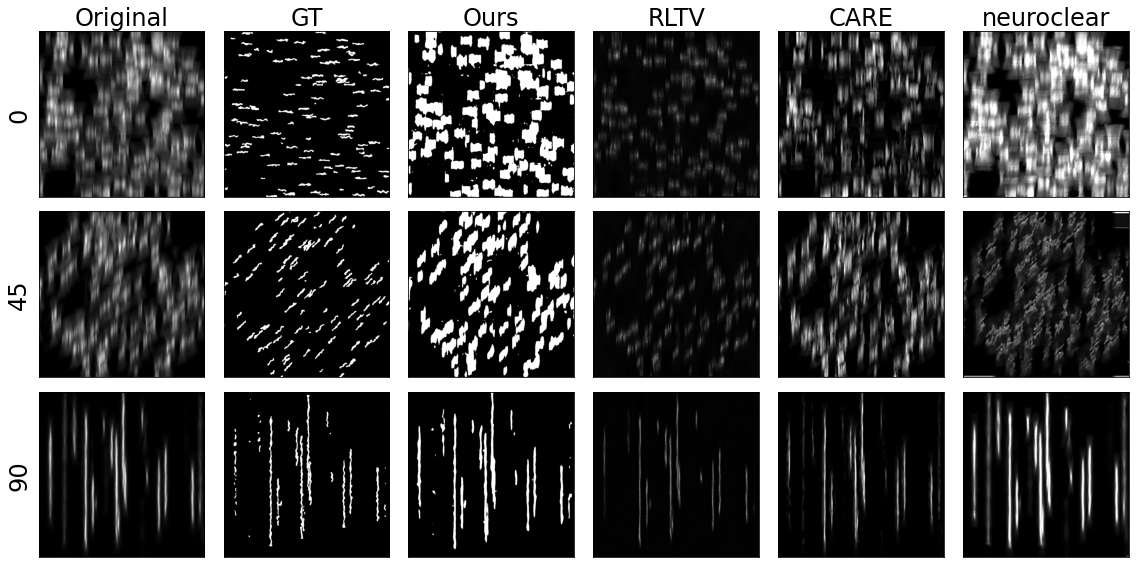

In [22]:
sec    = "yz"
start  = 425
range0  = 50
x_start =  0
x_end   = -1
y_start =  0
y_end   = -1
figsize = (16, 8)
fontsize = 24

figures = [
    [ln_original  , "Original"         ],
    [ln_label     , "GT"               ],
    [ln_tenet     , "Ours"             ],
    [ln_deconv    , "RLTV"        , - 1],
    [ln_care      , "CARE"        , - 1],
    [ln_neuroclear, "neuroclear"  , - 1],
]

fig_2_c = figure_2_c(
    figures = figures  ,
    sec     = sec      ,
    start   = start    ,
    range   = range0   ,
    x_start = x_start  ,
    x_end   = x_end    ,
    y_start = y_start  ,
    y_end   = y_end    ,
    figsize = figsize  ,
    fontsize = fontsize,
    figname  = "_results_for_paper/fig2_a/labels.pdf"
)

## e angle-wise IoU scores

In [ ]:
iou_care       = []
iou_deconv     = []
iou_neuroclear = []
iou_tenet      = []

for idx in tqdm(range(3),
                bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}"):
    # preprocess to 0 to 1
    label      = l_label     [idx] 
    deconv     = l_deconv    [idx] 
    neuroclear = l_neuroclear[idx] 
    care       = l_care      [idx] 
    tenet      = l_tenet     [idx] 

    th_care       = 0.1
    th_deconv     = 0.5
    th_neuroclear = 0.5
    th_tenet      = 0.5
    for ious, image, th in zip(
        [iou_care      ,
         iou_deconv    ,
         iou_neuroclear,
         iou_tenet     ,],
        [care      ,
         deconv    ,
         neuroclear,
         tenet     ,],
        [th_care      ,
         th_deconv    ,
         th_neuroclear,
         th_tenet     ,],
         ):
        iou_value = iou(image, label, threshold=th, smooth=0)
        ious.append(iou_value)

print(iou_deconv    )
print(iou_care      )
print(iou_neuroclear)
print(iou_tenet     )

In [ ]:
ious_ = [iou_deconv    ,
        iou_care      ,
        iou_neuroclear,
        iou_tenet     ,
        ]
labels = [
    "RLTV"       , 
    "CARE"       , 
    "Neuroclear" ,
    "Ours"       ,
    ]

def figure_2_e(ious_, labels, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.plot(np.array(ious).transpose(1,0),label=labels)
    plt.xticks([0, 1, 2], labels=["0", "45", "90"])
    plt.legend()
    plt.title("IoU scores")
    plt.show()

fig_2_d = figure_2_e(ious, labels, (8,4))

# fig.3 real data

In [ ]:
# load all images needed
original   = tifffile.imread(path_of(base, "fig3", "original"  ))[0]
care       = tifffile.imread(path_of(base, "fig3", "care"      ))
deconv     = tifffile.imread(path_of(base, "fig3", "deconv"    ))
neuroclear = tifffile.imread(path_of(base, "fig3", "neuroclear"))
tenet      = tifffile.imread(path_of(base, "fig3", "tenet"     ))[0]

# preprocess
original   = float_to_uint16(upsample3d(hill(norm(original  , bit=16))))
deconv     = float_to_uint16(upsample3d(hill(norm(deconv    , bit=16))))
neuroclear = float_to_uint16(upsample3d(norm(neuroclear, bit=16)))
care       = quantile_image(care_align(care), q_max=0.9975)

In [ ]:
# functions to generate images
def figure_3_a(figures, sec, start, range, 
               x_start,
               x_end  ,
               y_start,
               y_end  ,
               figsize = (20, 20),
               bounding_box_1_x_loc  = 150,
               bounding_box_1_y_loc  =   0,
               bounding_box_1_x_size = 200,
               bounding_box_1_y_size = 150,
               bounding_box_2_x_loc  = 600,
               bounding_box_2_y_loc  = 100,
               bounding_box_2_x_size = 200,
               bounding_box_2_y_size = 150,
               line_x_loc  = 30 ,
               line_y_loc  = 30 ,
               line_x_size = 1  ,
               line_y_size = 10 ,
               wspace=0, 
               color = "yellow",
               line_color = "red",
               title_font_size = 16,
               ):
    
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(len(figures), 4, figure=fig, wspace=0)
    fig.set_facecolor('white')
    line_values = []
    for i, img in enumerate(figures):
        # show large image
        ax = fig.add_subplot(gs[i, 0:2])
        if img[1]=="Original":
            scalebar = AnchoredSizeBar(ax.transData,
                           65, '20 µm', 'lower right', 
                           pad=0.3,
                           color=color,
                           frameon=False,
                           size_vertical=3,
                           fontproperties=fm.FontProperties(size=16),
                            )
            ax.add_artist(scalebar)
        # set bounding box1
        rect = patches.Rectangle(
            (bounding_box_1_x_loc , bounding_box_1_y_loc),
             bounding_box_1_x_size, bounding_box_1_y_size,
            linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        # set bounding box2
        rect = patches.Rectangle(
            (bounding_box_2_x_loc , bounding_box_2_y_loc),
             bounding_box_2_x_size, bounding_box_2_y_size,
            linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        # set title
        ax.text(20,310, img[1], fontsize=title_font_size, color=color,
                bbox=dict(facecolor="black", alpha=0.8))
        # remove axis
        ax.set_xticks([])
        ax.set_yticks([])
        image_to_show = mip(img[0], sec=sec, start=start, range=range,
                            )[y_start:y_end, x_start:x_end,]
        vmin = image_to_show.min()
        vmax = image_to_show.max()
        ax.imshow(image_to_show, cmap="gray",vmin=vmin, vmax=vmax)
        # show image in bounding box 1
        ax = fig.add_subplot(gs[i, 2])
        ax.set_xticks([])
        ax.set_yticks([])
        image_to_zoom1 = image_to_show[
            bounding_box_1_y_loc:bounding_box_1_y_loc+bounding_box_1_y_size,
            bounding_box_1_x_loc:bounding_box_1_x_loc+bounding_box_1_x_size,
        ]
        ax.imshow(image_to_zoom1, cmap="gray", vmin=vmin, vmax=vmax)
        # show image in bounding box 2
        ax = fig.add_subplot(gs[i, 3])
        ax.set_xticks([])
        ax.set_yticks([])
        rect = patches.Rectangle(
            (line_x_loc, line_y_loc ),
             line_x_size,line_y_size,
            linewidth=2, edgecolor=line_color, facecolor='none')
        ax.add_patch(rect)

        image_to_zoom2 = image_to_show[
            bounding_box_2_y_loc:bounding_box_2_y_loc+bounding_box_2_y_size,
            bounding_box_2_x_loc:bounding_box_2_x_loc+bounding_box_2_x_size,
        ]
        
        line_value = image_to_zoom2[
            line_y_loc:line_y_loc+line_y_size,
            line_x_loc:line_x_loc+line_x_size,
        ]
        line_values.append(line_value)
        ax.imshow(image_to_zoom2, cmap="gray", vmin=vmin, vmax=vmax)
    plt.tight_layout(w_pad=wspace)
    plt.show()
    return fig, line_values

# plot here
figures = [
    [original  , "Original"                         ],
    [tenet     , "Ours"                             ],
    [deconv    , "RLTV"                             ],
    [care      , "CARE (Weigert, et.al. 2017)"      ],
    [neuroclear, "neuroclear (Park, et.al. 2022)"   ],
]

fig_3_a, line_values = figure_3_a(
    figures,
    sec      = "xz"     ,
    start    = 200      ,
    range    = 100      ,
    x_start  = 0        ,
    x_end    = 1024     ,
    y_start  = 0        ,
    y_end    = 333      ,
    figsize  = (22,18)  ,
    bounding_box_1_x_loc  = 150,
    bounding_box_1_y_loc  =  10,
    bounding_box_1_x_size = 200,
    bounding_box_1_y_size = 150,
    bounding_box_2_x_loc  = 650,
    bounding_box_2_y_loc  =  80,
    bounding_box_2_x_size = 200,
    bounding_box_2_y_size = 150,
    line_x_loc            = 88 ,
    line_y_loc            = 70 ,
    line_x_size           = 1  ,
    line_y_size           = 40 ,
    wspace                = 0,
    color                 = "yellow",
    line_color            = "yellow",
    title_font_size       = 20,
)
# save

In [ ]:
# functions to generate graphs
def figure_3_b(figures, line_values, figsize=(20,3),
               x_label=None, y_label=None,
               micron_per_pixel=0.33):
    window = 1
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(1, len(figures), figure=fig, wspace=0.2)
    for i, v in enumerate(line_values):
        ax = fig.add_subplot(gs[0, i])
        x = np.linspace(0, len(v) * micron_per_pixel, len(v))
        n_v = (v - v.min()) / (v.max() - v.min())
        n_v = np.convolve(n_v[:, 0], np.ones(window)/window, mode="same")
        ax.plot(x, n_v, label=figures[i][1])
        plt.xticks(rotation=90)
        plt.yticks(rotation=90)
        if i == 0:
            ax.set_ylabel(y_label, fontsize=14)
            ax.set_xlabel(x_label, fontsize=14)
    plt.subplots_adjust(wspace=0.5, left=0.2)
    plt.show()
    return fig
    
fig_3_b = figure_3_b(figures[:],
                     line_values[:],
                     x_label="distance (µm)",
                     y_label="Normalized Intensity",)

In [ ]:
figures = [
    [original  , ""                         ],
    [tenet     , ""                             ],
    [deconv    , "RLTV"                             ],
    [care      , "CARE (Weigert, et.al. 2017)"      ],
    [neuroclear, "neuroclear (Park, et.al. 2022)"   ],
]

fig_1_a, line_values = figure_3_a(
    figures,
    sec      = "yz"     ,
    start    = 300      ,
    range    = 100      ,
    x_start  = 300      ,
    x_end    = 1024     ,
    y_start  = 0        ,
    y_end    = 333      ,
    figsize  = (16,18)  ,
    bounding_box_1_x_loc  = 0,
    bounding_box_1_y_loc  = 0,
    bounding_box_1_x_size = 0,
    bounding_box_1_y_size = 0,
    bounding_box_2_x_loc  = 0,
    bounding_box_2_y_loc  = 0,
    bounding_box_2_x_size = 0,
    bounding_box_2_y_size = 0,
    line_x_loc            = 88 ,
    line_y_loc            = 70 ,
    line_x_size           = 0  ,
    line_y_size           = 0  ,
    wspace                = 0,
    color                 = "yellow",
    line_color            = "yellow",
    title_font_size       = 20,
)